### 필요 라이브러리 import
---
tarfile - tar 아카이브를 읽고 쓸 수 있게 해줍니다.
urllib - url 작업을 위한 라이브러리 입니다.


In [52]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 필요한 이미지파일의 path 지정
---
필요한 모든 파일의 경로를 지정 후 불러왔습니다.

In [53]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/m0image.png'# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/quickpic.jpg'# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/chipmonk.jpg'# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.

img_cath = os.getenv('HOME')+'/aiffel/human_segmentation/images/sadcat.png'
img_cath2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bcat.jpg'
img_bath = os.getenv('HOME')+'/aiffel/human_segmentation/images/frostpunk0.png'

img_orig = cv2.imread(img_path)
img_orig2 = cv2.imread(img_path2)
img_orig3 = cv2.imread(img_path3)

img_cat = cv2.imread(img_cath)
img_bcat = cv2.imread(img_cath2)
img_back = cv2.imread(img_bath)

print (img_orig.shape)

(466, 350, 3)


### 모델 설정
---
모델을 생성하고, 전처리 및 세그멘테이션 할 수 있도록 함수를 설정합니다.

In [54]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전 학습 가중치 이용
---
구글에서 제공한 파일을 다운로드하여 모델이 사전학습 할 수 있도록 합니다.

In [55]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


### 준비한 이미지를 로드
---
인물 사진을 학습한 모델에 로드합니다.

In [56]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(466, 350, 3) (513, 385, 3) 15


### 구글의 라벨
---
참조용으로 적었습니다.

In [57]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 세그멘테이션
---
사람을 검출합니다.

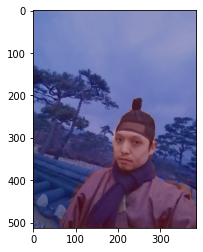

In [58]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 사이즈 복구
---
세그멘테이션 마스크 결과물을 원래 사이즈로 복구합니다.

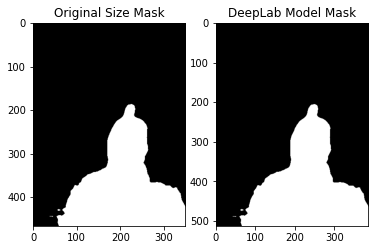

In [59]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게하기
---
배경을 모두 흐리게합니다.

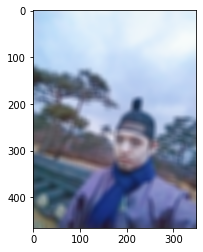

In [60]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경만 추출
---
세그멘테이션 마스크를 이용하여 배경만 추출합니다.

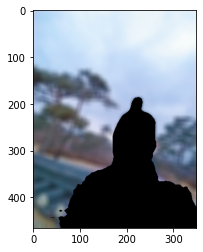

In [61]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### shallow focus 완성
---
세그멘테이션된 원본 부분과 추출한 흐린 배경을 합쳐서 완성합니다.

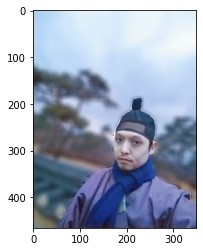

In [62]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 두 번째 인물사진
---
같은 방식으로 두 번째 인물사진을 완성합니다.

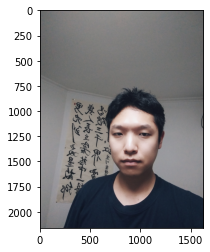

In [31]:
# img_orig2 = cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB)
plt.imshow(img_orig2)
plt.show()

(2160, 1620, 3) (513, 384, 3) 15


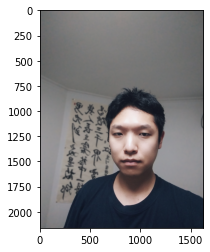

In [50]:
img_resized, seg_map = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

img_mask_up = cv2.resize(img_mask, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# ax = plt.subplot(1,2,1)
# plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
# ax.set_title('Original Size Mask')

# ax = plt.subplot(1,2,2)
# plt.imshow(img_mask, cmap=plt.cm.binary_r)
# ax.set_title('DeepLab Model Mask')

img_orig_blur = cv2.blur(img_orig2, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
# plt.show()

img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 세 번째 인물사진
---
같은 방식으로 세 번째 인물사진을 완성합니다.

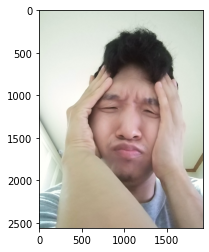

In [38]:
# img_orig3 = cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB)
plt.imshow(img_orig3)
plt.show()

(2560, 1920, 3) (513, 384, 3) 15


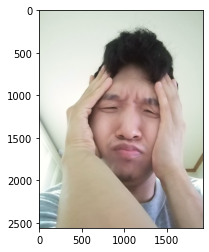

In [49]:
img_resized, seg_map = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# ax = plt.subplot(1,2,1)
# plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
# ax.set_title('Original Size Mask')

# ax = plt.subplot(1,2,2)
# plt.imshow(img_mask, cmap=plt.cm.binary_r)
# ax.set_title('DeepLab Model Mask')

img_orig_blur = cv2.blur(img_orig3, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
# plt.show()

img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 사진
---
유사한 방식으로 고양이 사진을 완성합니다.

In [63]:
img_resized, seg_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(179, 282, 3) (325, 513, 3) 8


### 레이블은 변경해 줍니다.
---
모델에서 레이블을 사람(15)이 아닌 고양이(8)로 변경해줍니다.

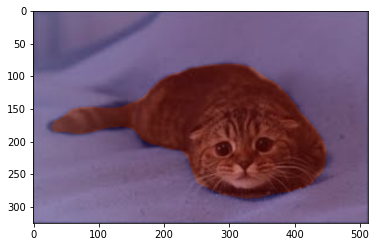

In [43]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

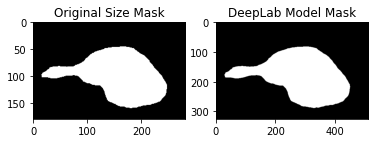

In [46]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

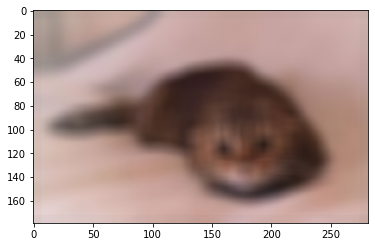

In [47]:
img_cat_blur = cv2.blur(img_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

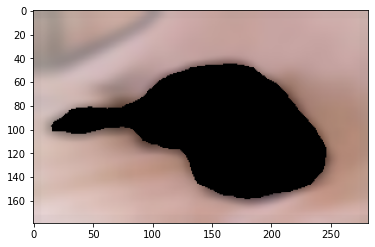

In [48]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

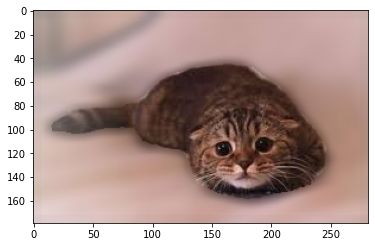

In [49]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 교환
---
배경전환 크로마키사진을 만듭니다.\
보조출연 아르바이트시 분장했던 조선좀비 사진을 이용하여 프로스트펑크(게임 frostpunk) 배경과 합성했습니다.\
추위와 싸울 준비가 된 것 같습니다.

In [51]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(466, 350, 3) (513, 385, 3) 15


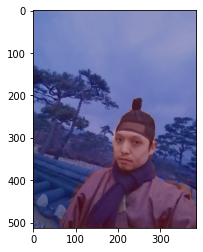

In [61]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

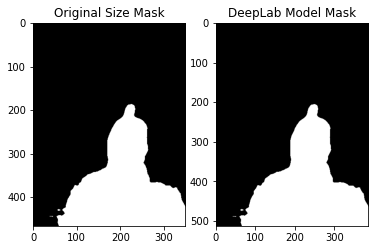

In [62]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [55]:
img_back_resized, seg_back_map = MODEL.run(img_back)
print (img_back.shape, img_back_resized.shape, seg_back_map.max())

(466, 650, 3) (367, 513, 3) 15


### 프로스트 펑크 사진입니다.
---
모두 굳센 각오가 느껴집니다.

(466, 650, 3)


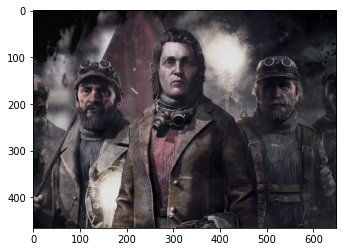

In [64]:
img_back2 = cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB)
plt.imshow(img_back2)
print(img_back.shape)
plt.show()

### 배경 사이즈 조정
---
배경 사이즈 조정을 안 하면 오류가 발생합니다.\
따라서 잘라냈습니다.\
크기가 다른 사진에 넣는 방법을 알아보려했지만, 찾지 못 했습니다.

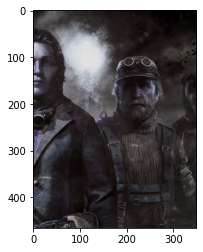

In [111]:
# modified_back = cv2.resize(img_back, dsize=(350, 466), interpolation=cv2.INTER_LINEAR)
oriback = img_back.copy()
cropback = img_back[0:466, 300:650]
plt.imshow(cropback)
plt.show()

### 완성
---
배경에 제 분장사진을 집어넣어서 추위 및 굶주림의 싸움에 합류했습니다.\
그냥 합류했더니 제 복장의 색이 약간 분위기에 적합하지 않은 듯 하여 회색처리했습니다.\
이번 겨울도 잘 견뎌낼 수 있을 것입니다.

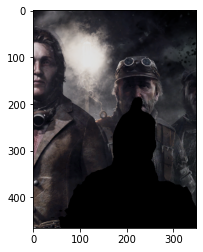

In [109]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cropback, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

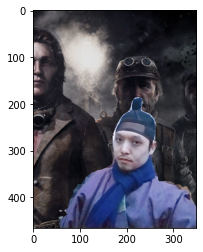

In [115]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

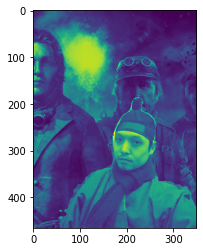

In [123]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2GRAY))
plt.show()

### 참조 블로그 url
---

https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0
https://hoony-gunputer.tistory.com/entry/opencv-python-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0-%EC%B2%98%EB%A6%AC%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%95%A9%EC%84%B1
https://076923.github.io/posts/Python-opencv-9/